# Visualize predictions using a custom 2D U-net algorithm that is trained on CORONAL slices (Original or Derived)

  - 4-class preictions (Medial, Lateral, Superior, Inferior)
  - validation dice of 0.82 for medial, 


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import load_model
import glob
from keras.utils import plot_model
import matplotlib as mpl
import imageio

In [100]:
os.chdir('/content/drive/MyDrive/01_eom_segmentation/02_training/03_2dunet_108uc_coronal/')
base_dir=os.getcwd()
print(base_dir)

/content/drive/MyDrive/01_eom_segmentation/02_training/03_2dunet_108uc_coronal


In [101]:
from helpers.data import *
from helpers.datagenerator import *
from helpers.model import *
from helpers.visualize import *
from helpers.postprocessing import *

In [102]:
data_folder='../compiled_npys'

/content/drive/MyDrive/01_eom_segmentation/02_training/03_2dunet_108uc_coronal/unet_2d_unet_64sz_nadp_2d_2dvp_4sb_100pb_500ep_nasf_<tensorflow.python.keras.optimizer_v2.learning_rate_schedule.CosineDecayRestarts object at 0x7f92705ba080>lr_400ww_dicels/20210103-191758/02_unetunet_2d_unet_64sz_nadp_2d_2dvp_4sb_100pb_500ep_nasf_<tensorflow.python.keras.optimizer_v2.learning_rate_schedule.CosineDecayRestarts object at 0x7f92705ba080>lr_400ww_dicels.h5


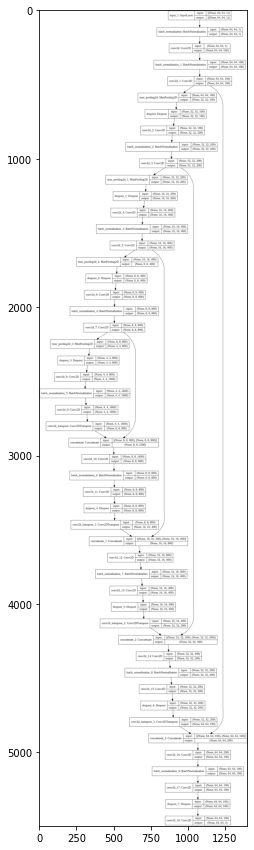

In [118]:
IMG_SIZE=64
iteration_dir=os.path.join(base_dir, 'unet_2d_unet_64sz_nadp_2d_2dvp_4sb_100pb_500ep_nasf_<tensorflow.python.keras.optimizer_v2.learning_rate_schedule.CosineDecayRestarts object at 0x7f92705ba080>lr_400ww_dicels/20210103-191758')
weights_path=glob.glob(iteration_dir+'/*.h5')[0]
print(weights_path)
unet_2D=load_model(weights_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_wbce_loss':dice_wbce_loss})
#unet_2D.summary(line_length=150)

#Visualize schematic
mpl.rcParams['figure.figsize'] = (15,15)  # plot sizes
plot_model(unet_2D, to_file='unet_schematic.png', show_shapes=True)
plt.imshow(imageio.imread('unet_schematic.png'))



# Load with UC test scan (nrrd) - wasn't trained on (single example, need to evaluate on all test scans - as of now ~55 series left for testing). 

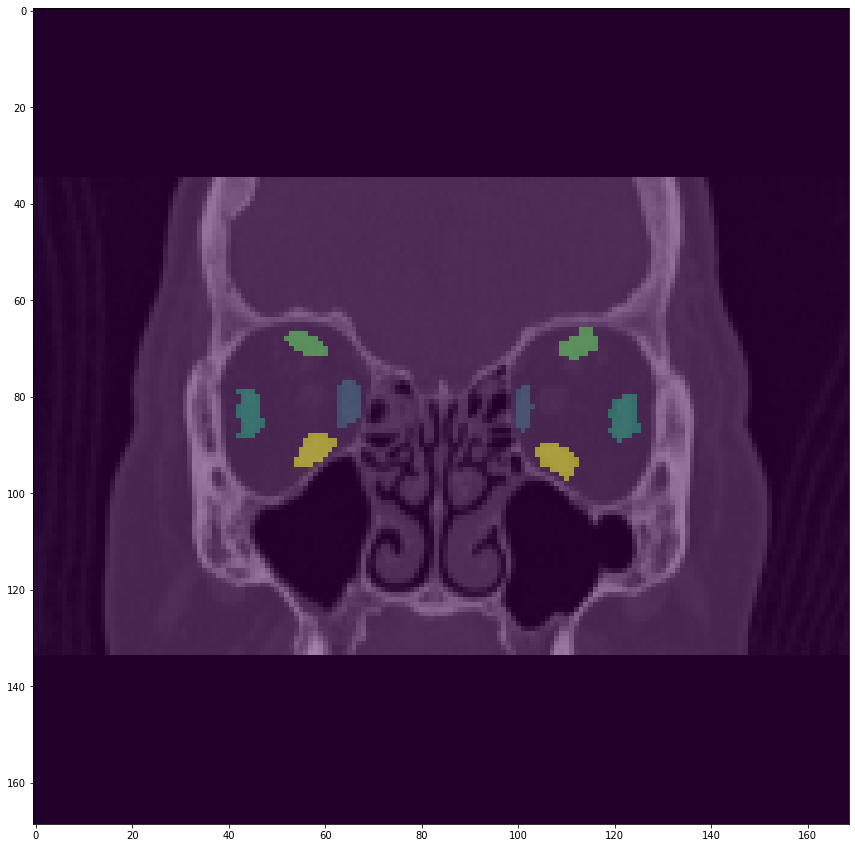

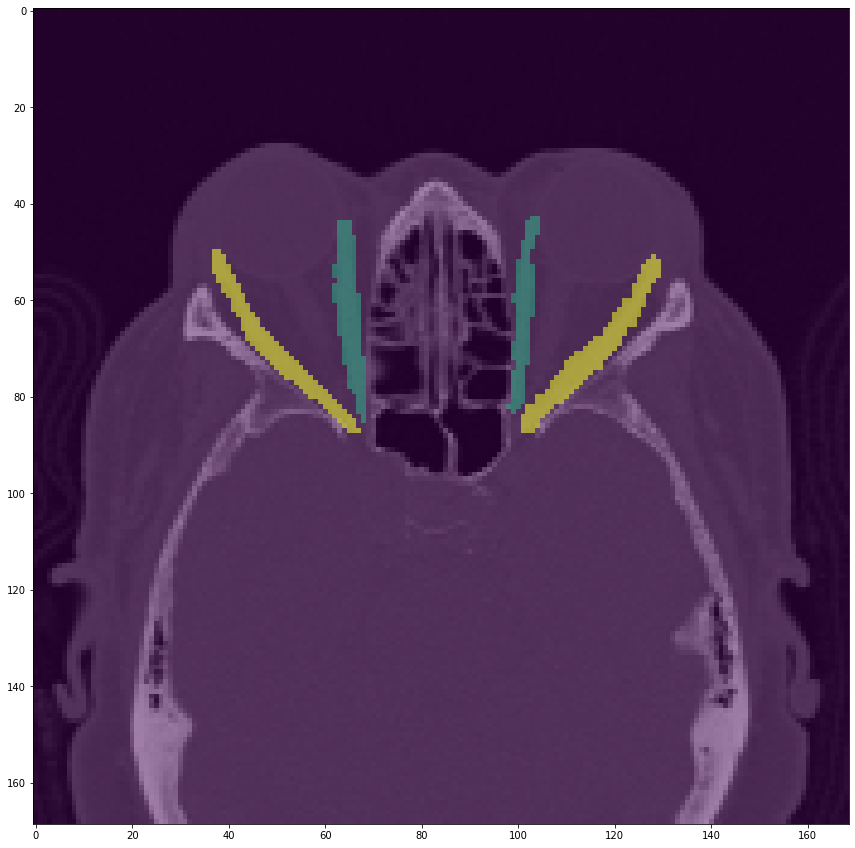

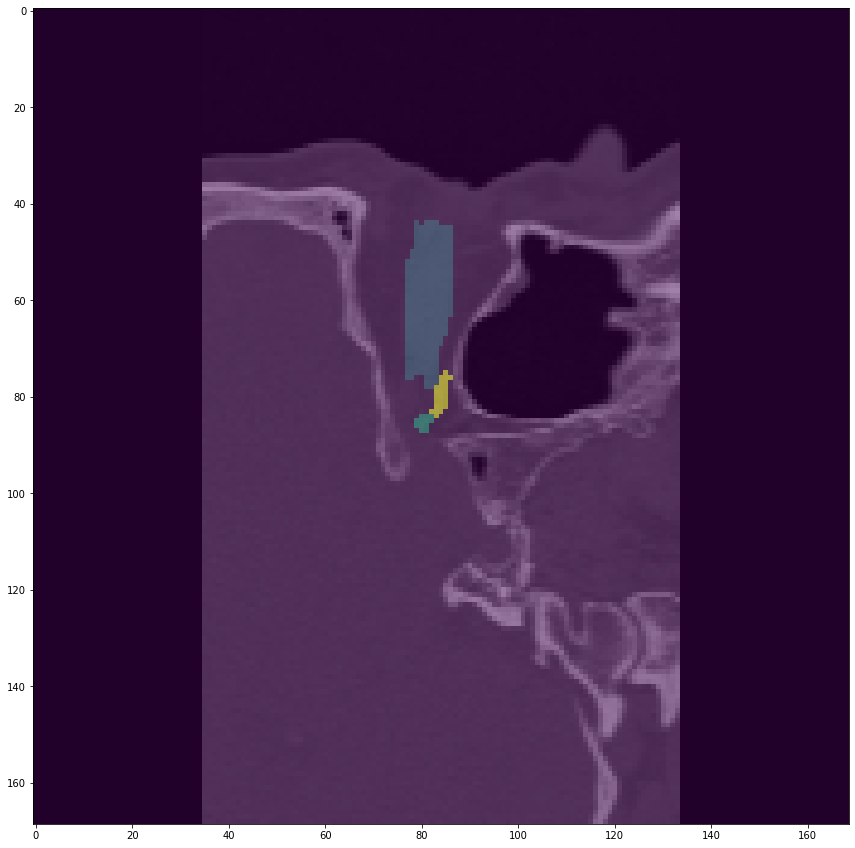

In [123]:
test_dir='../uc_test_data'

!pip install pynrrd
import nrrd

scan, h = nrrd.read(os.path.join(test_dir, 'SCAN.nrrd'))
mask, h = nrrd.read(os.path.join(test_dir, 'MASK.nrrd'))


visualize_scan_mask(scan, mask)



 Windowed scans


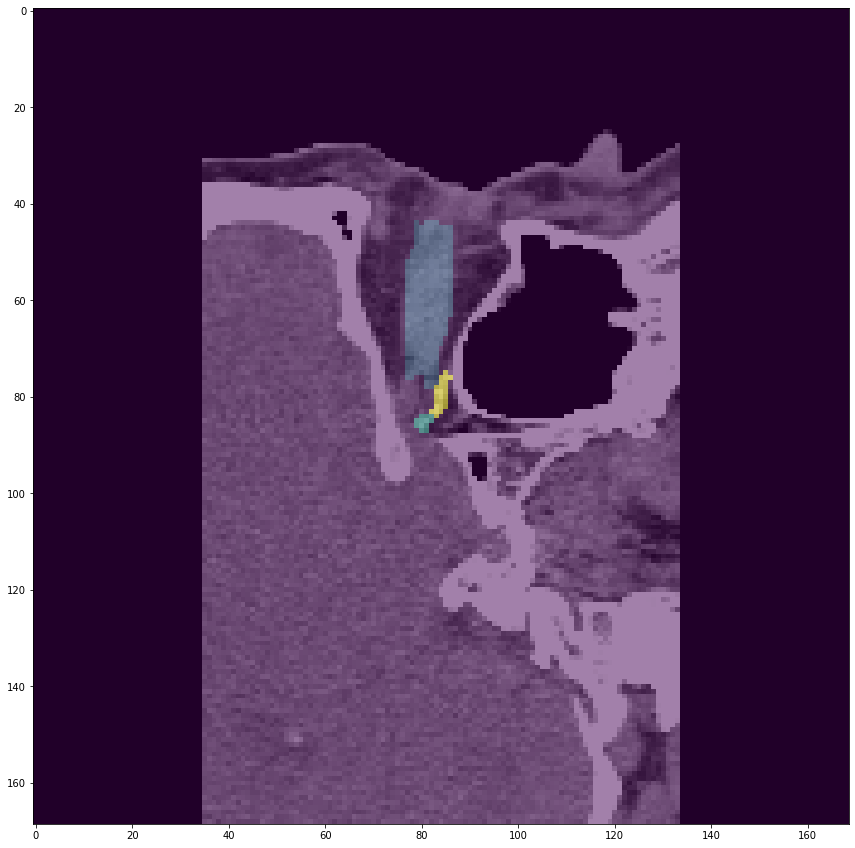

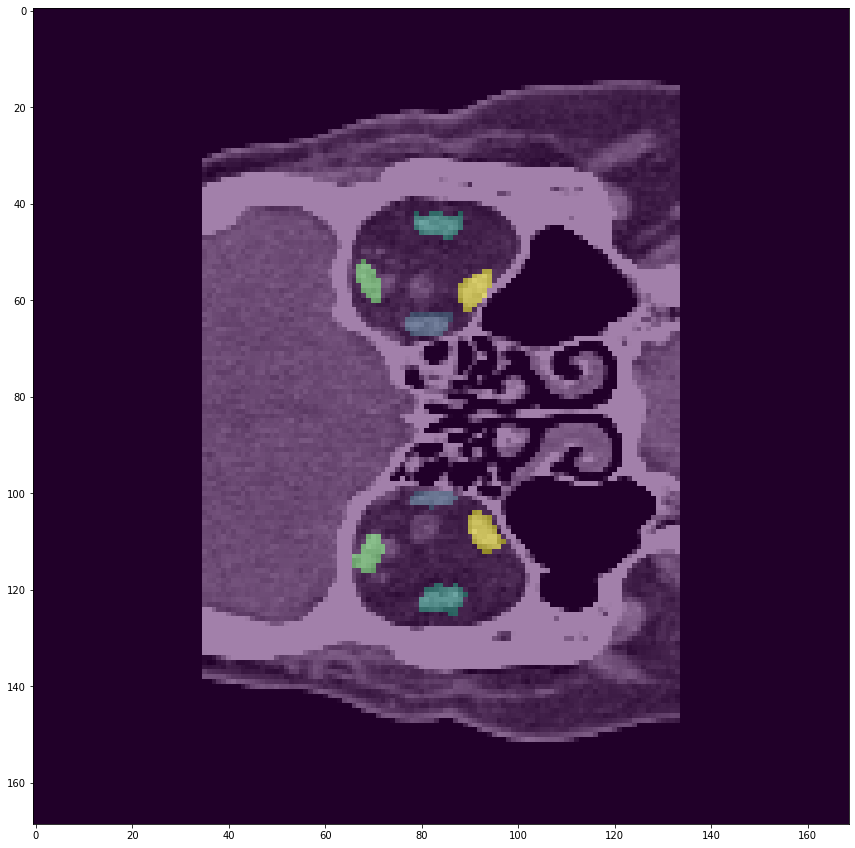

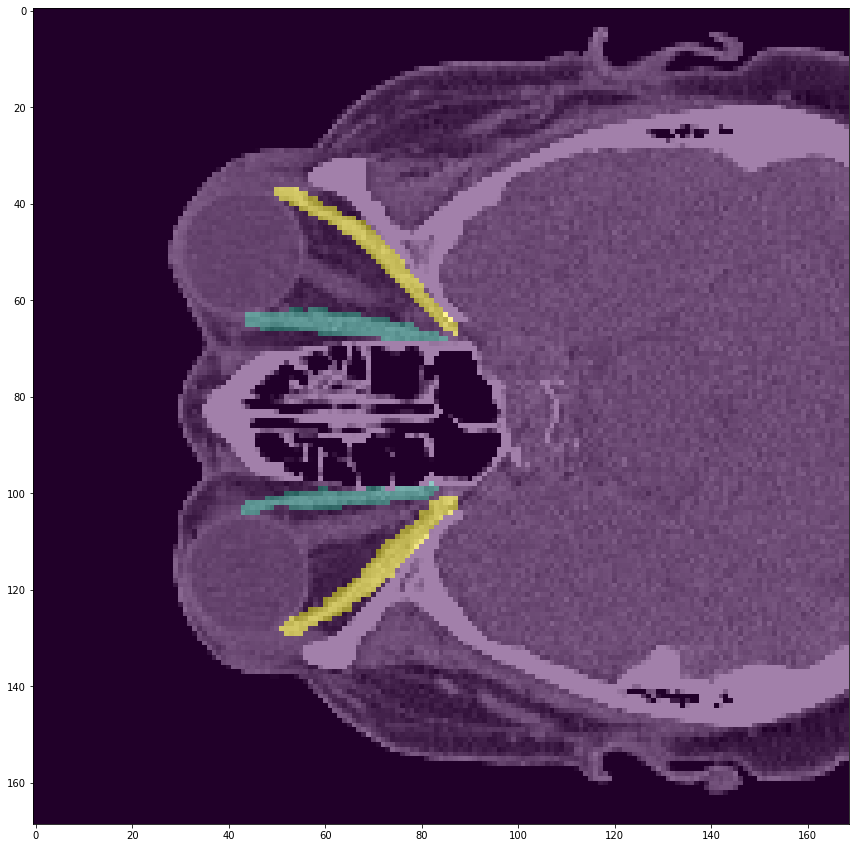

In [124]:
scan=np.transpose(scan, (2,0,1))
mask=np.transpose(mask, (2,0,1))

scan = window_image(image=scan, window_center=0, window_width=400)

print("\n\n Windowed scans")
visualize_scan_mask(scan, mask)

scans=[]
masks=[]

scans.append(scan)
masks.append(mask)

(169, 169, 169)
(169, 169, 169)
10
10
(64, 64)
(64, 64)
0


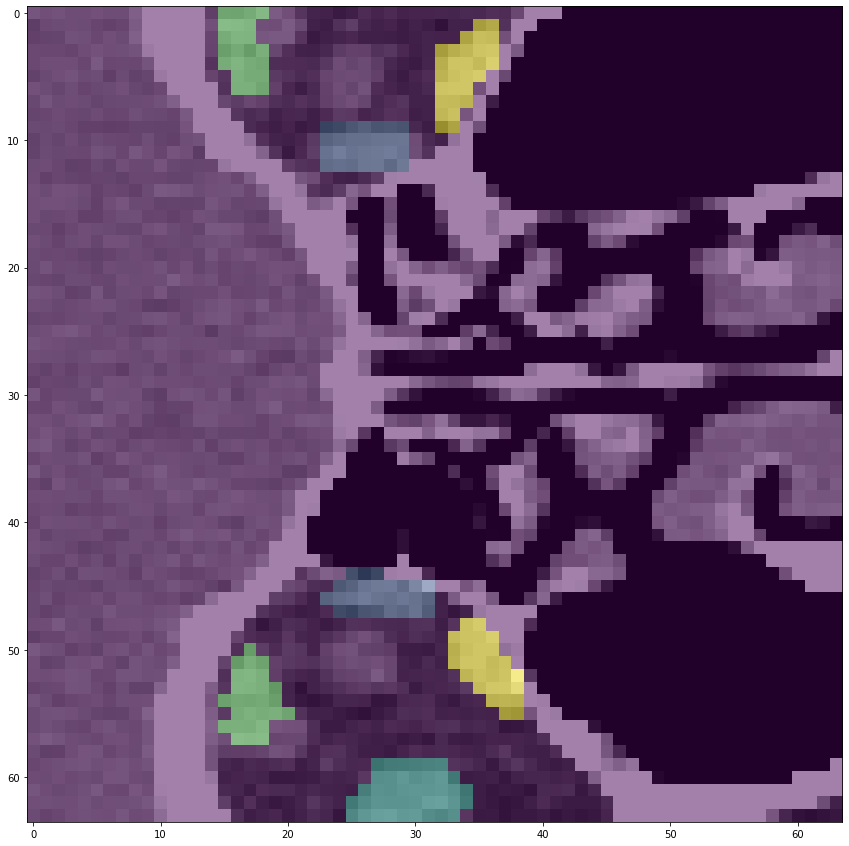

In [125]:
print(scans[0].shape)
print(masks[0].shape)

x, y = get_2d_cor_patches(scans, masks, num_patches_required = 10, sz = IMG_SIZE)

print(len(x))
print(len(y))

print(x[0].shape)
print(y[0].shape)

ID=0
print(ID)
plt.imshow(x[ID], cmap='gray')
plt.imshow(y[ID], alpha=0.5)
plt.show()

(10, 64, 64, 1)
(10, 64, 64, 4)


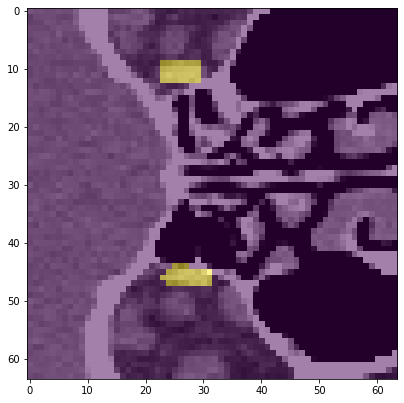

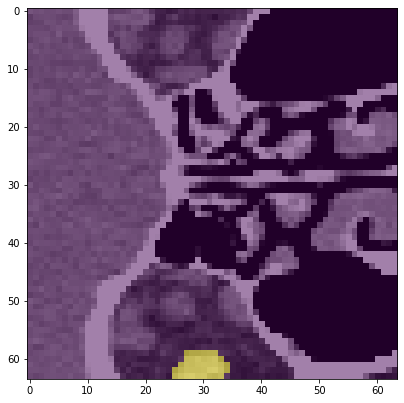

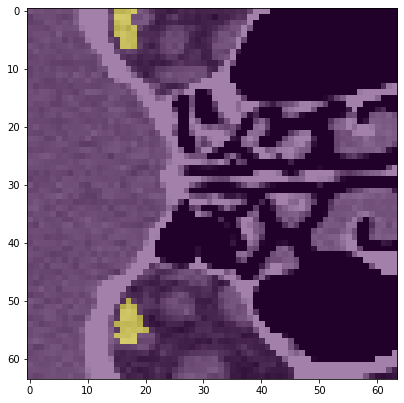

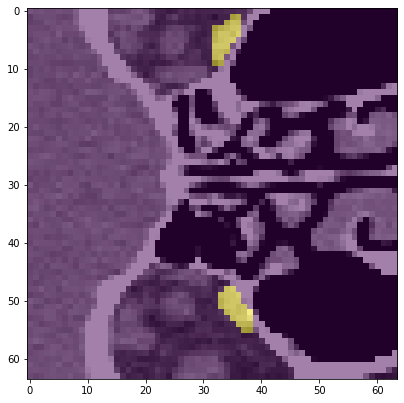

[0. 1.]


In [126]:
x, y = turn_2d_patches_list_to_numpy(x, y, num_classes=4)
print(x.shape)
print(y.shape)

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y[0,:,:,0], alpha=0.5)
plt.show()

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y[0,:,:,1], alpha=0.5)
plt.show()

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y[0,:,:,2], alpha=0.5)
plt.show()

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y[0,:,:,3], alpha=0.5)
plt.show()

print(np.unique(y[0,:,:,0]))

## Making predictions

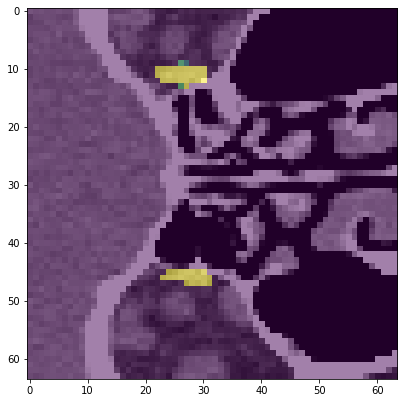

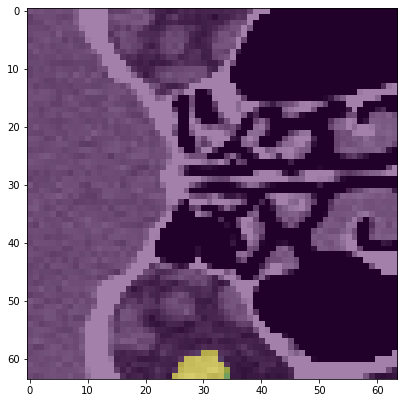

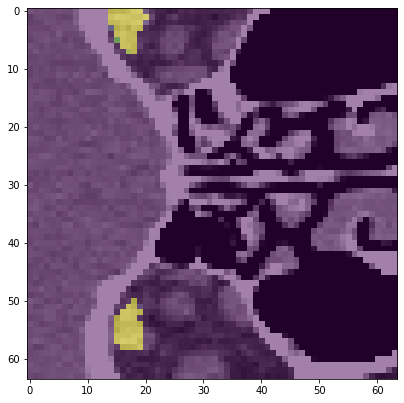

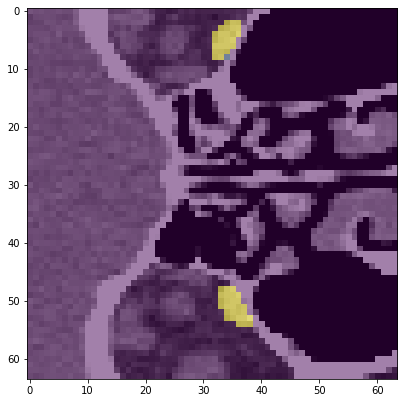

In [127]:
y_pred=unet_2D.predict(x)


plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y_pred[0,:,:,0], alpha=0.5)
plt.show()

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y_pred[0,:,:,1], alpha=0.5)
plt.show()

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y_pred[0,:,:,2], alpha=0.5)
plt.show()

plt.subplot(221)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y_pred[0,:,:,3], alpha=0.5)
plt.show()

Choosing right probability threshold for binary mask 

0
0.02697495183044316


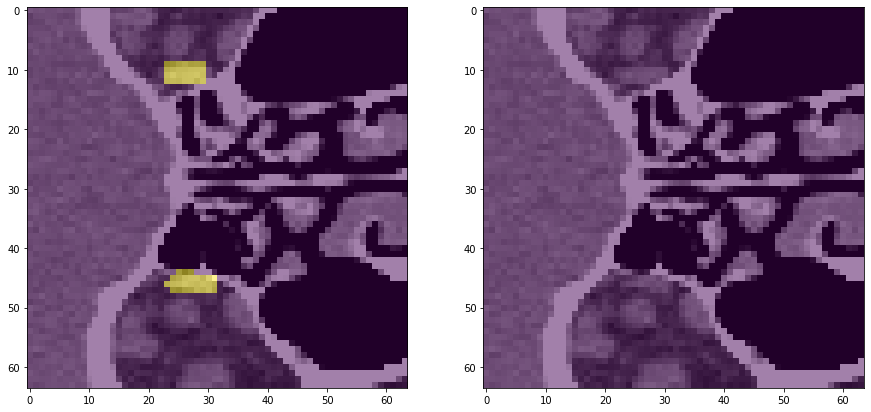

0.1
0.822429906542056


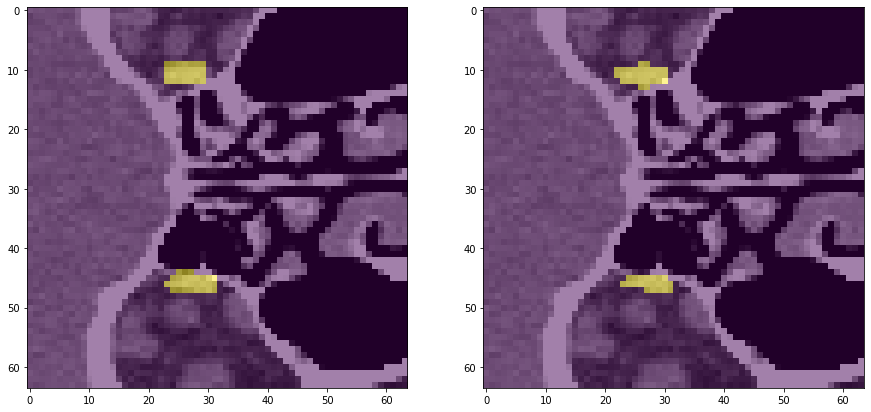

0.2
0.822429906542056


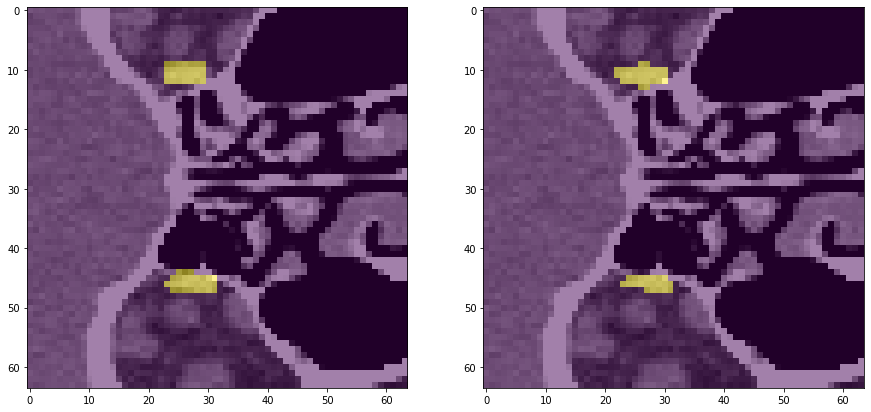

0.30000000000000004
0.822429906542056


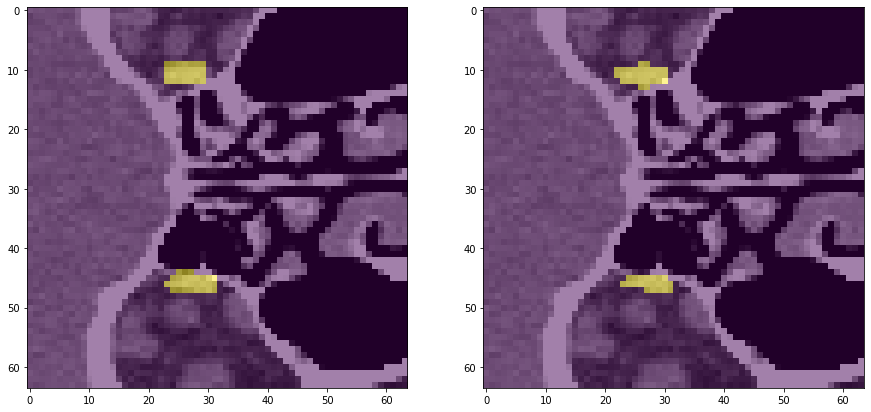

0.4
0.8113207547169812


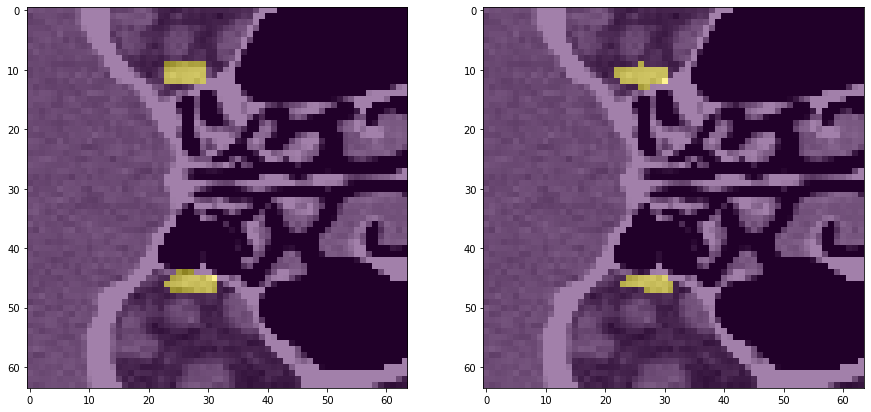

0.5
0.8113207547169812


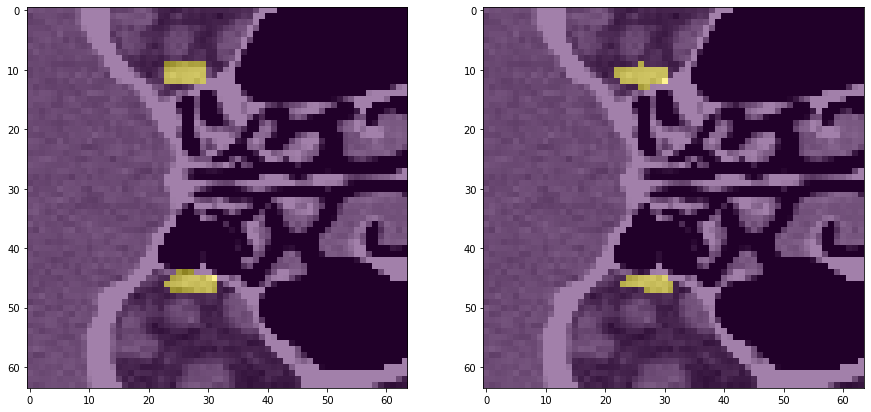

0.6
0.8113207547169812


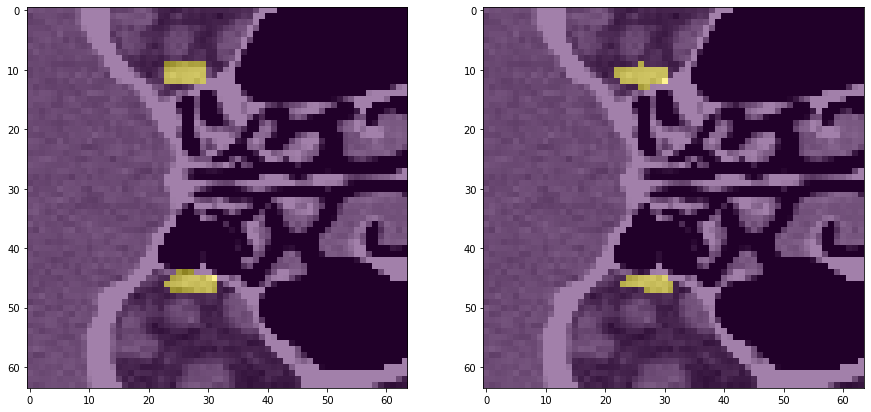

0.7
0.8


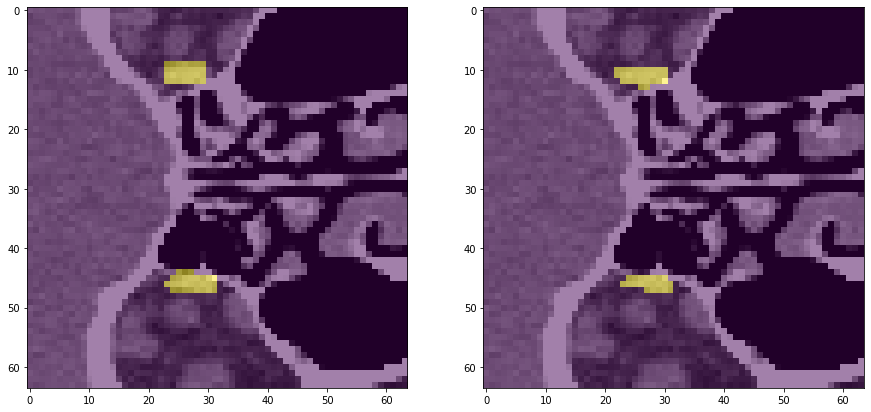

0.7999999999999999
0.8076923076923077


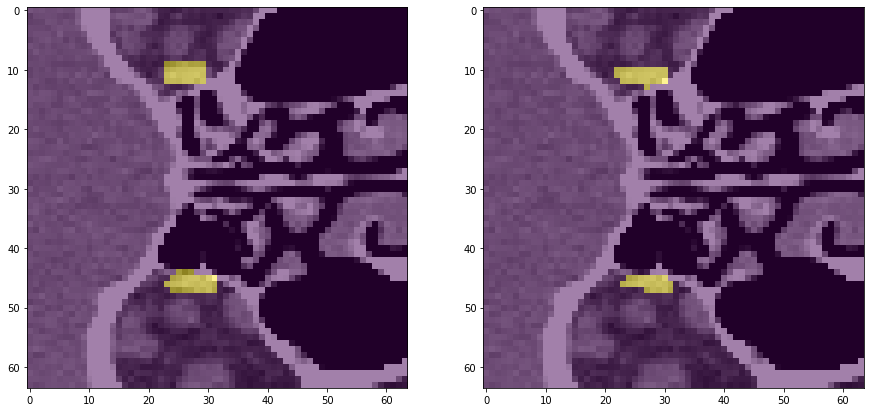

0.8999999999999999
0.8076923076923077


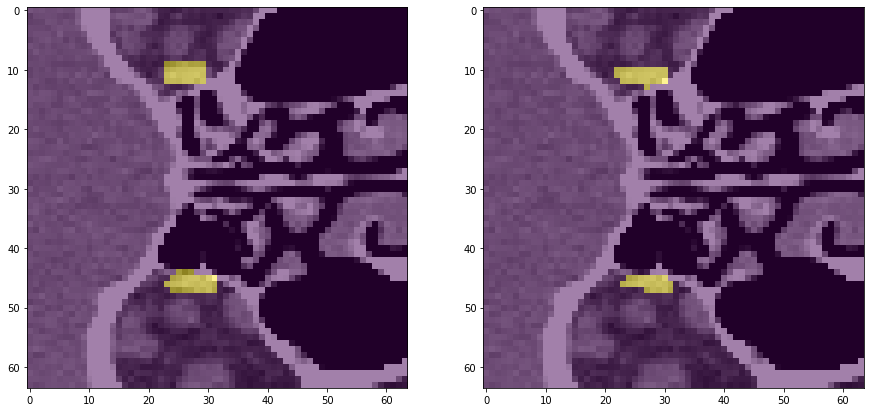

0.9999999999999999
0.8080808080808081


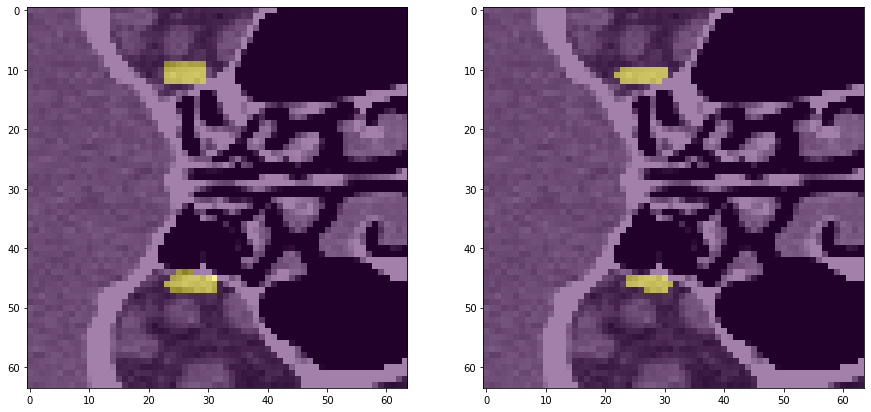

In [129]:
threshold=0

while threshold <=1:
    
    y_pred_binary=np.zeros(y_pred.shape)
    y_pred_binary[y_pred>=threshold]=1
    
    
    im1 = np.asarray(y[0,:,:,0]).astype(np.bool)
    im2 = np.asarray(y_pred_binary[0,:,:,0]).astype(np.bool)

    # Compute Dice coefficient
    im_sum = im1.sum() + im2.sum()
    intersection = np.logical_and(im1, im2)
    d= 2. * intersection.sum() / im_sum
    print(threshold)
    print(d)
    
    fig = plt.figure()
    
    plt.subplot(1,2,1)
    plt.imshow(x[0,:,:,0],cmap='gray')
    plt.imshow(y[0,:,:,0],alpha=0.5)
    plt.subplot(1,2,2)
    
    plt.imshow(x[0,:,:,0],cmap='gray')
    plt.imshow(y_pred_binary[0,:,:,0],alpha=0.5)
    plt.show()

    threshold+=0.1

# Load a test scan without mask from TCIA source - for new predictions


In [10]:
data_folder_tcia_hnscc='../tcia_scans/CPTAC-HNSCC'

In [11]:
# How many patients do we have 
tcia_patient_ids_anonymized=[]
tcia_patient_paths = []


# Select patient within the disease yes/no folder
for patient_id_anonymized in os.listdir(data_folder_tcia_hnscc):
# Exclude patients that I have marked an exclude within them 
    if 'exclude' not in patient_id_anonymized:

        # Here is where we're collecting patient level EDA 

        # Get the anonymized patient ID
        tcia_patient_ids_anonymized.append(patient_id_anonymized)

        # Get the path corresponding to that patient
        patient_path=os.path.join(data_folder_tcia_hnscc,patient_id_anonymized)
        tcia_patient_paths.append(patient_path)


        # Get the number of studies within that patient
        # Sometimes here, the studies selected in iBroker will show up with all the slices
        # Studies may be downloaded that do not have valid data as well

print(tcia_patient_ids_anonymized)

print("\n\nNumber of patients in our TCIA dataset = "+str(len(tcia_patient_ids_anonymized)))
print("\n\nNumber of patients paths in our TCIA dataset = "+str(len(tcia_patient_paths)))

['C3N-03433', 'C3N-03027', 'C3N-03782', 'C3N-03457', 'C3N-03009', 'C3N-03783', 'C3N-03028', 'C3N-03008', 'C3N-03015', 'C3N-01752', 'C3N-03785', 'C3N-03889', 'C3N-04277']


Number of patients in our TCIA dataset = 13


Number of patients paths in our TCIA dataset = 13


In [132]:
!pip install pydicom
import pydicom as dcm

tcia_scan_paths=[]

for tcia_patient_path in tcia_patient_paths:
    
    for dirpaths, dirnames, filenames in os.walk(tcia_patient_path):
        if len(glob.glob(dirpaths+'/*.dcm'))>3:
            img=dcm.dcmread(glob.glob(dirpaths+'/*.dcm')[0])
            tcia_scan_paths.append(dirpaths)
            
print("Number of scan series in TCIA dataset: " + str(len(tcia_scan_paths)))

Number of scan series in TCIA dataset: 58


In [135]:
!pip install pydicom

import random
import pydicom as dcm
import numpy as np
from scipy.ndimage import zoom, binary_fill_holes
import glob
from math import sqrt


# Step 1 - import dicoms into numpy array
tcia_scan_path=random.choice(tcia_scan_paths)
tcia_scan_path=tcia_scan_paths[1]
print(tcia_scan_path)

slices = [dcm.dcmread(s) for s in glob.glob(tcia_scan_path+'/*.dcm')]
slices.sort(key = lambda x: int(x.InstanceNumber))
scan_raw = np.stack([s.pixel_array for s in slices], axis=-1)
print(scan_raw.shape)

# Step 2 - Rescale raw ct slices into isometric resampled voxels of 1mm edge - using only mandatory DICOM attributes
x_eq = slices[0].PixelSpacing[0]
y_eq = slices[0].PixelSpacing[1]
z_eq = sqrt((slices[1].ImagePositionPatient[0] - slices[0].ImagePositionPatient[0])**2 +
            (slices[1].ImagePositionPatient[1] - slices[0].ImagePositionPatient[1])**2 +
            (slices[1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])**2)

print(x_eq, y_eq, z_eq)

scan = zoom(scan_raw, (x_eq, y_eq, z_eq), order=2)
print(scan.shape)



#Step 3 - Ensure coronal slices are in y axis - how can we determine acquisition slice
scan2 = np.transpose(scan, (1,0,2))

# step 4 - Apply S-T window - custom at window center 0, window width 400 (used for training model)
def window_image(image, window_center=0, window_width=400):
	img_min = window_center - window_width // 2
	img_max = window_center + window_width // 2
	window_image = image.copy()
	window_image[window_image < img_min] = img_min
	window_image[window_image > img_max] = img_max
	
	return window_image

x = window_image(scan2, window_center=0, window_width=400)

# Convert to X vector 
x = np.reshape(x, (1,x.shape[0], x.shape[1], 1))
print(x.shape)


# Predict y-mask
y_pred = unet_2D.predict(x)

# Postprocessing to fill holes in prediction 
#mask_2_filled = ndimage.binary_fill_holes(mask_2)

# Visualize
plt.imshow(x[0,:,:,0], cmap='gray')
plt.imshow(y_pred[0,:,:,0], alpha=0.5)
plt.imshow(y_pred[0,:,:,1], alpha=0.5)
plt.imshow(y_pred[0,:,:,2], alpha=0.5)
plt.imshow(y_pred[0,:,:,3], alpha=0.5)
plt.show()




../tcia_scans/CPTAC-HNSCC/C3N-03027/03-16-2001-HeadTWARZOCZASZKA Adult-43093/10.000000-Twarzo SC  0.6  H40s-79338
(512, 512, 559)
0.390625 0.390625 0.4000000000000057
(200, 200, 224)


ValueError: ignored